In [1]:
%pip install pyarrow rulefit

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from plotnine import *
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import statsmodels.api as sm

import rulefit

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

print('\nok')


ok


In [3]:
# sensitivity:
# min ref_length > 10; < 100
# max n_authors of 50
# cited_by_count > 10; < 100

# by publication year
# solo; 2-author

In [4]:
raw_df = pd.read_feather('data/analysis_df.feather').set_index('id')
raw_df

,is_retracted,publication_year,cited_by_count,ref_length,journal_id,journal_name,n_authors,abstract_indexed,has_doi,has_pmid,concept0,concept1,disrupt,focal_refs,len_I,len_J,novelty_title,novelty_abstract,n_citing
id,,,,,,,,,,,,,,,,,,,
W1000085140,0,2015,8,21,V17140621,Clinical Biochemistry,8,1,1,1,Medicine,None,0.000000,21.0,4.0,4.0,NaN,NaN,8.0
W1000238170,0,2015,23,34,V2764928002,Redox biology,7,1,1,1,Chemistry,Cell biology,0.629630,34.0,22.0,5.0,1.083342,0.644107,27.0
W1000402150,0,2015,1,1,V2764481192,Procedia. Economics and finance,4,1,1,0,Business,None,1.000000,1.0,1.0,0.0,NaN,NaN,1.0
W10005641,0,2013,40,47,V188605413,Carbon,7,1,1,0,None,Optoelectronics,-0.459459,47.0,10.0,27.0,NaN,NaN,37.0
W1000768039,0,2015,50,32,V127530304,Journal of Materials Processing Technology,5,1,1,0,None,None,0.000000,32.0,25.0,25.0,NaN,NaN,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W99822253,1,2012,4,3,V125754415,Proceedings of the National Academy of Science...,7,0,1,1,Medicine,Immunology,1.000000,3.0,3.0,0.0,NaN,NaN,3.0
W998644059,0,2015,4,47,V186231457,Agroforestry Systems,3,1,1,0,Geography,Socioeconomics,-0.500000,47.0,1.0,3.0,NaN,NaN,4.0
W998753227,0,2015,16,38,V186231457,Agroforestry Systems,3,1,1,0,None,None,-0.333333,38.0,6.0,12.0,NaN,NaN,18.0


In [5]:
X_names = 'is_retracted publication_year cited_by_count ref_length n_authors'.split()
Y_names = 'novelty_title novelty_abstract disrupt'.split()
wanted_columns = Y_names + X_names
# df = df[df.disrupt.notna()]
df = raw_df[wanted_columns].copy()
df

,novelty_title,novelty_abstract,disrupt,is_retracted,publication_year,cited_by_count,ref_length,n_authors
id,,,,,,,,
W1000085140,NaN,NaN,0.000000,0,2015,8,21,8
W1000238170,1.083342,0.644107,0.629630,0,2015,23,34,7
W1000402150,NaN,NaN,1.000000,0,2015,1,1,4
W10005641,NaN,NaN,-0.459459,0,2013,40,47,7
W1000768039,NaN,NaN,0.000000,0,2015,50,32,5
...,...,...,...,...,...,...,...,...
W99822253,NaN,NaN,1.000000,1,2012,4,3,7
W998644059,NaN,NaN,-0.500000,0,2015,4,47,3
W998753227,NaN,NaN,-0.333333,0,2015,16,38,3


# model selection

novelty_title 39019
Training
0 LinearRegression() 0.17676461845206048
1 RandomForestRegressor(n_estimators=400, n_jobs=-1) 0.8361391658141832
2 HistGradientBoostingRegressor() 0.4497788402680374
Validation
M0 = 0.17161109914670392
M1 = 0.2990507879649216
M2 = 0.41944493866002386
Final test scores
LinearRegression()
-0.0411226488282439
RandomForestRegressor(n_estimators=400, n_jobs=-1)
0.2988837514613919
HistGradientBoostingRegressor()
0.4250412672042775
Elapsed time to compute the importances: 34.300 seconds


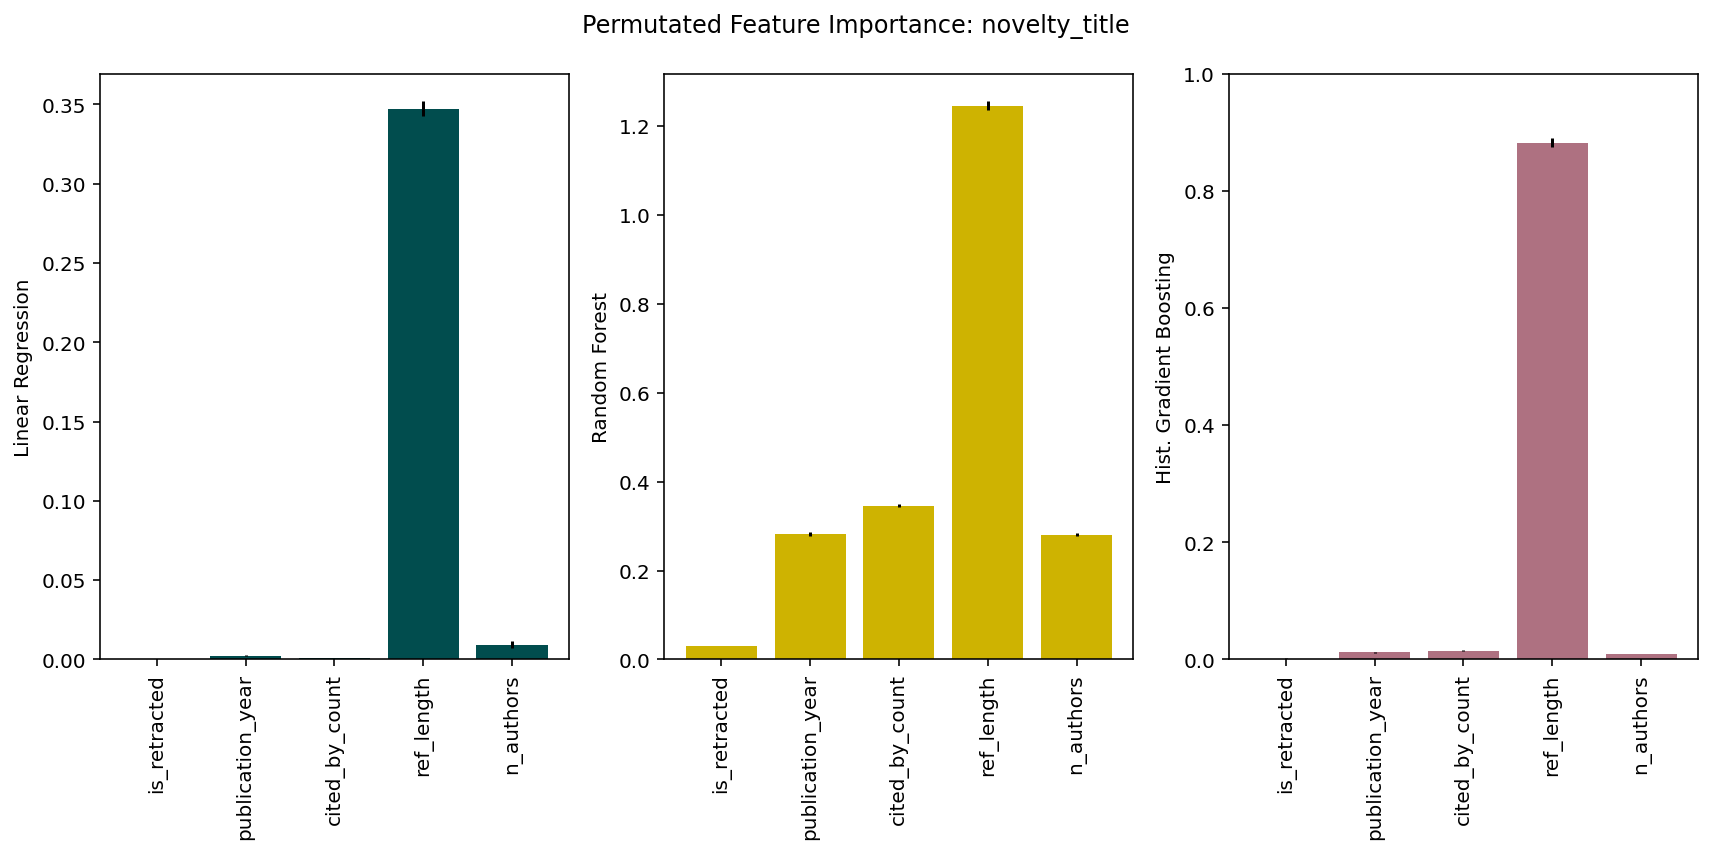

novelty_abstract 38810
Training
0 LinearRegression() 0.11127458500540566
1 RandomForestRegressor(n_estimators=400, n_jobs=-1) 0.8058352231243641
2 HistGradientBoostingRegressor() 0.2206804496449446
Validation
M0 = 0.0732735150972345
M1 = 0.05285599031496304
M2 = 0.1924117090495387
Final test scores
LinearRegression()
0.08781495165915021
RandomForestRegressor(n_estimators=400, n_jobs=-1)
0.03122506306204975
HistGradientBoostingRegressor()
0.1839937536106162
Elapsed time to compute the importances: 34.183 seconds


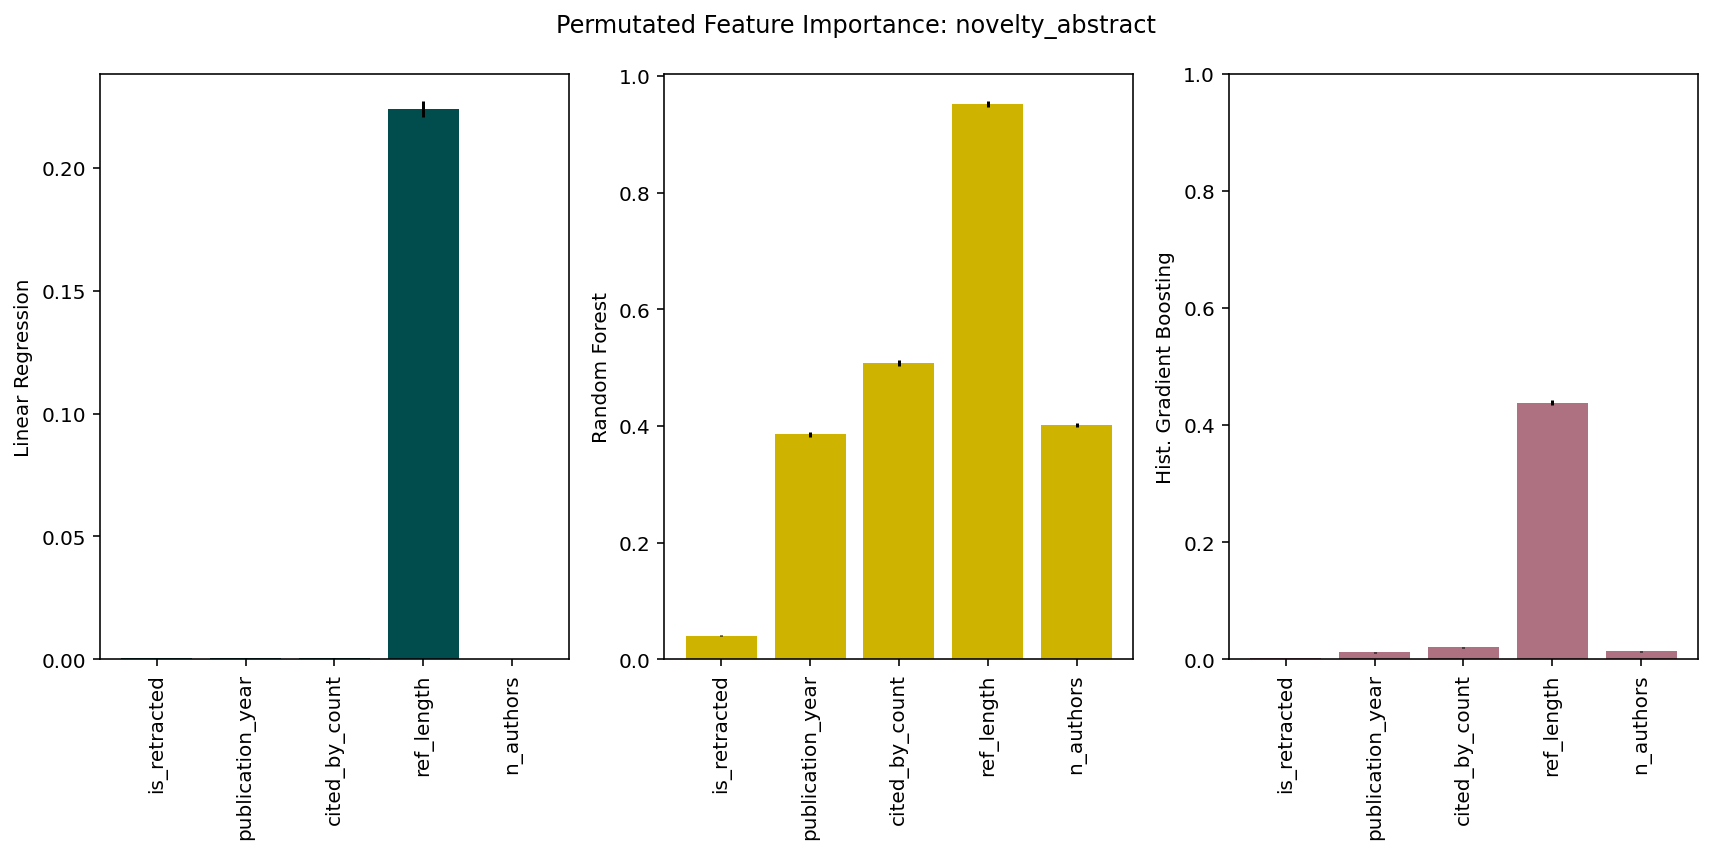

disrupt 97338
Training
0 LinearRegression() 0.09603469159923739
1 RandomForestRegressor(n_estimators=400, n_jobs=-1) 0.7521449620494483
2 HistGradientBoostingRegressor() 0.3254273599928844
Validation
M0 = 0.09498439933069096
M1 = 0.1519851394860458
M2 = 0.3096702885457666
Final test scores
LinearRegression()
0.0981529723965121
RandomForestRegressor(n_estimators=400, n_jobs=-1)
0.14609674537291517
HistGradientBoostingRegressor()
0.30814782676003694
Elapsed time to compute the importances: 94.016 seconds


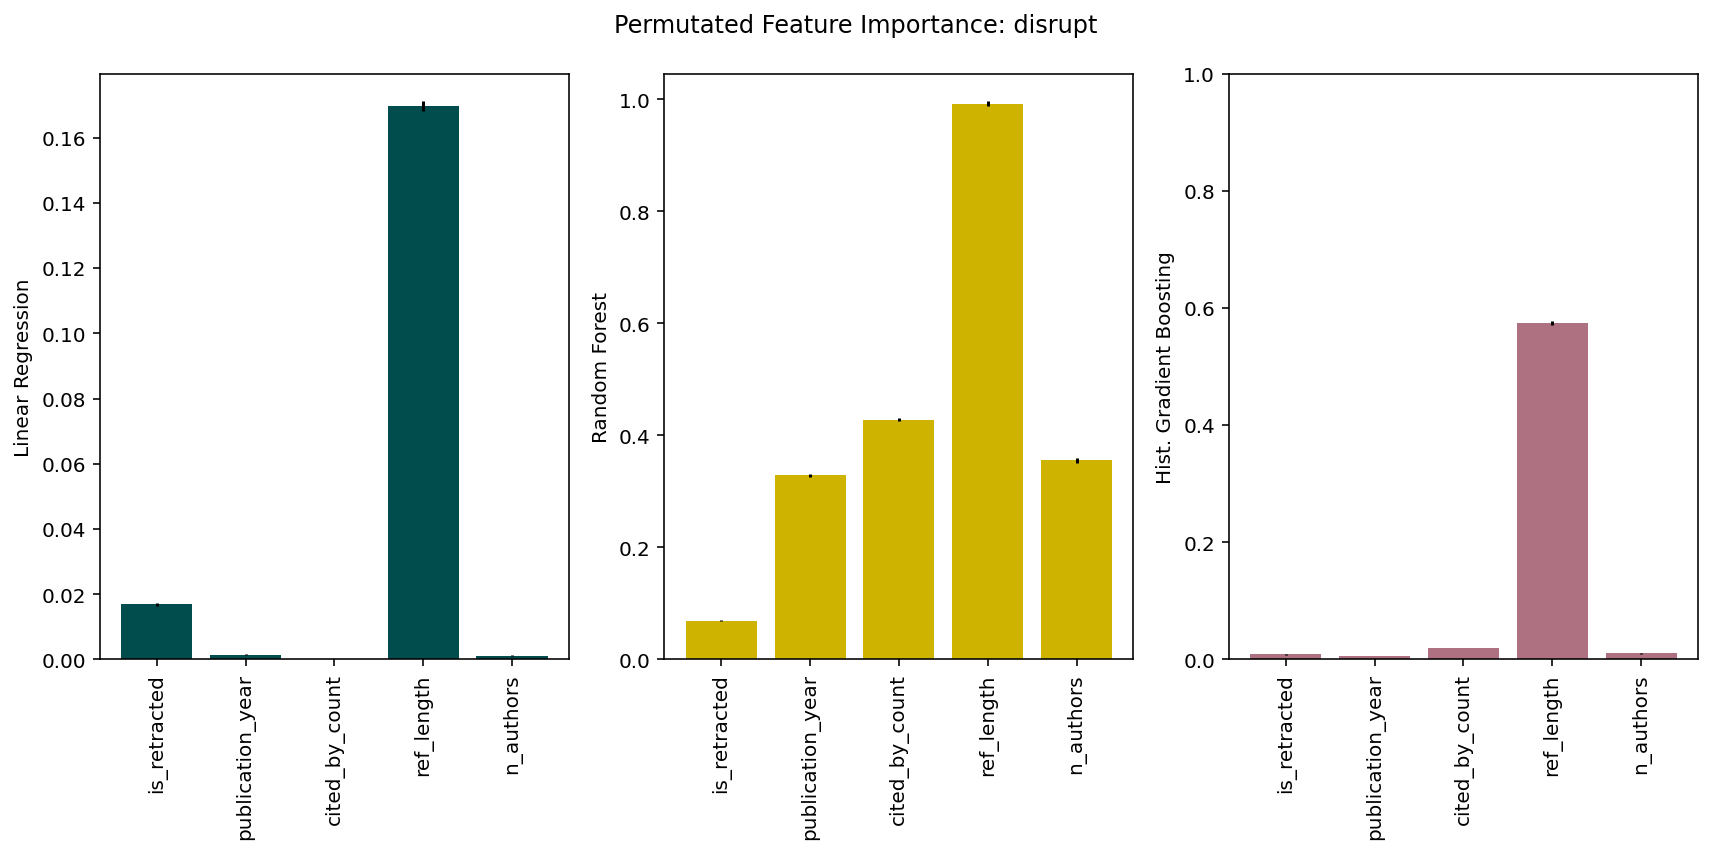

In [14]:
for y_name in Y_names:
    start_time = time.time()
    outcome_df = raw_df[[y_name, *X_names]].dropna()
    n = len(outcome_df)
    print(y_name, n)
    X = outcome_df[X_names]
    y = outcome_df[y_name]

    ml_models = [
        LinearRegression(),
        RandomForestRegressor(n_estimators=400, n_jobs=-1),
        HistGradientBoostingRegressor(),
        # SGDRegressor() # this has never performed well
    ]

    # first we do train_test split
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    print("Training")
    for i, model in enumerate(ml_models):
        score_mean = model.fit(X_train, y_train).score(X_train, y_train).mean()
        print(i, model, score_mean)

    # estimate cross validation performance of each model
    print("Validation")
    for i, model in enumerate(ml_models):
        print(f"M{i} =", cross_val_score(model, X_train, y_train).mean())

    print('Final test scores')
    for model in ml_models:
        print(model)
        model.fit(X_train, y_train)
        print(model.score(X_test, y_test))

    #Feature importance based on feature permutation
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    with sklearn.config_context(working_memory=128):
        # can't use n_jobs > 1 because it eats too much memory on S4 server
        permimps = [
            permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=1)
            for model in ml_models
        ]


    fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=True)
    names = ["Linear Regression", "Random Forest", "Hist. Gradient Boosting"]
    colors = ['#014d4e', '#ceb301', '#ae7181']
    for i, ax in enumerate(axes):
        imp = permimps[i]
        name = names[i]
        color = colors[i]
        axes[i].bar(X_names, imp.importances_mean, yerr=imp.importances_std, color=color)
        axes[i].set_ylabel(name)
        plt.ylim([0, None])
        plt.sca(ax)
        plt.xticks(rotation=90)
    fig.suptitle("Permutated Feature Importance: "+y_name)
    fig.tight_layout() # blows out figsize with suptitle
    plt.show()
    elapsed_time = time.time() - start_time
    print(f"Elapsed time for {y_name}: {elapsed_time:.1f} seconds")
